# Взвешенный ансамбль по временным интервалам

**Стратегия**: Обучаем отдельные модели для разных фаз аукциона, поскольку корреляции признаков и волатильность таргета различаются на протяжении аукционного окна.

**Ключевые выводы из EDA**:
- Волатильность таргета снижается в ходе аукциона (позже = более предсказуемо)
- Корреляции признак-таргет различаются между ранней и поздней фазами аукциона
- Определение цены происходит постепенно

**Подход**:
1. Разбиваем аукцион на фазы: Ранняя (0-180с), Средняя (190-360с), Поздняя (370-540с)
2. Обучаем специализированные модели CatBoost для каждой фазы
3. Опционально: обучаем глобальную модель как базовую
4. Сравниваем предсказания фазовых моделей с глобальной

## 1. Настройка и загрузка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import gc

from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

PROJECT_ROOT = Path('/root/Optiver')
DATA_DIR = PROJECT_ROOT / 'data'
TRAIN_PATH = DATA_DIR / 'train.csv'

print(f'Train file exists: {TRAIN_PATH.exists()}')

Train file exists: True


In [2]:
# Оптимизированные типы данных
dtypes = {
    'stock_id': 'int16',
    'date_id': 'int16',
    'seconds_in_bucket': 'int16',
    'imbalance_size': 'float32',
    'imbalance_buy_sell_flag': 'int8',
    'reference_price': 'float32',
    'matched_size': 'float32',
    'far_price': 'float32',
    'near_price': 'float32',
    'bid_price': 'float32',
    'bid_size': 'float32',
    'ask_price': 'float32',
    'ask_size': 'float32',
    'wap': 'float32',
    'target': 'float32',
    'time_id': 'int32',
    'row_id': 'str'
}

print('Загрузка данных...')
df = pd.read_csv(TRAIN_PATH, dtype=dtypes)
print(f'Размер: {df.shape}')
print(f'Память: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB')

# Удаляем строки с пропущенным таргетом
df = df.dropna(subset=['target'])
print(f'После удаления NaN таргетов: {len(df):,}')

Загрузка данных...
Размер: (5237980, 17)
Память: 639.2 MB
После удаления NaN таргетов: 5,237,892


In [3]:
# Анализ фаз аукциона
print('Распределение временных интервалов аукциона:')
print(f"Диапазон секунд: {df['seconds_in_bucket'].min()} - {df['seconds_in_bucket'].max()}")
print(f"Уникальных значений: {df['seconds_in_bucket'].nunique()}")

# Определяем фазы аукциона
EARLY_END = 180   # Первые 3 минуты
MID_END = 360     # Средние 3 минуты  
LATE_END = 540    # Последние 3 минуты

df['auction_phase'] = pd.cut(
    df['seconds_in_bucket'],
    bins=[-1, EARLY_END, MID_END, LATE_END],
    labels=['early', 'mid', 'late']
)

print('\nРаспределение по фазам:')
print(df['auction_phase'].value_counts().sort_index())

# Статистика таргета по фазам
print('\nСтатистика таргета по фазам:')
print(df.groupby('auction_phase')['target'].agg(['mean', 'std', 'count']))

Распределение временных интервалов аукциона:
Диапазон секунд: 0 - 540
Уникальных значений: 55

Распределение по фазам:
auction_phase
early    1809444
mid      1714219
late     1714229
Name: count, dtype: int64

Статистика таргета по фазам:
                   mean        std    count
auction_phase                              
early          0.001894   9.210640  1809444
mid           -0.109238  10.783418  1714219
late          -0.038087   8.197351  1714229


## 2. Генерация признаков

Переиспользуем признаки из advanced_features.ipynb плюс признаки фазы.

In [ ]:
def create_all_features(df):
    """
    Комплексная генерация признаков, объединяющая все подходы.
    """
    print('Создание признаков...')
    start = time.time()
    
    # Сортировка для корректного вычисления лагов
    df = df.sort_values(['stock_id', 'date_id', 'seconds_in_bucket']).reset_index(drop=True)
    
    # === Базовые признаки ===
    df['book_imbalance'] = df['bid_size'] - df['ask_size']
    df['wap_ref_diff'] = df['wap'] - df['reference_price']
    df['spread'] = df['ask_price'] - df['bid_price']
    df['imbalance_ratio'] = df['imbalance_size'] / (df['matched_size'] + 1e-8)
    df['mid_price'] = (df['bid_price'] + df['ask_price']) / 2
    df['spread_pct'] = df['spread'] / (df['wap'] + 1e-8) * 10000
    df['normalized_book_imbalance'] = df['book_imbalance'] / (df['bid_size'] + df['ask_size'] + 1e-8)
    
    # Обработка far/near price
    df['has_far_price'] = (~df['far_price'].isna()).astype('int8')
    df['has_near_price'] = (~df['near_price'].isna()).astype('int8')
    df['far_price'] = df['far_price'].fillna(df['reference_price'])
    df['near_price'] = df['near_price'].fillna(df['reference_price'])
    df['far_ref_diff'] = df['far_price'] - df['reference_price']
    df['near_ref_diff'] = df['near_price'] - df['reference_price']
    
    # === Временные/лаговые признаки ===
    group = df.groupby(['stock_id', 'date_id'])
    
    # Лаговые признаки
    df['imbalance_size_lag1'] = group['imbalance_size'].shift(1)
    df['imbalance_size_lag2'] = group['imbalance_size'].shift(2)
    df['matched_size_lag1'] = group['matched_size'].shift(1)
    df['bid_size_lag1'] = group['bid_size'].shift(1)
    df['ask_size_lag1'] = group['ask_size'].shift(1)
    df['wap_lag1'] = group['wap'].shift(1)
    df['book_imbalance_lag1'] = group['book_imbalance'].shift(1)
    
    df['imbalance_delta'] = df['imbalance_size'] - df['imbalance_size_lag1']
    df['matched_delta'] = df['matched_size'] - df['matched_size_lag1']
    df['wap_delta'] = df['wap'] - df['wap_lag1']
    df['book_imbalance_delta'] = df['book_imbalance'] - df['book_imbalance_lag1']
    df['bid_size_delta'] = df['bid_size'] - df['bid_size_lag1']
    df['ask_size_delta'] = df['ask_size'] - df['ask_size_lag1']
    
    df['imbalance_roll_mean3'] = group['imbalance_size'].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )
    df['imbalance_roll_std3'] = group['imbalance_size'].transform(
        lambda x: x.rolling(3, min_periods=1).std()
    )
    
    # Признаки времени
    df['time_remaining'] = 540 - df['seconds_in_bucket']
    df['auction_progress'] = df['seconds_in_bucket'] / 540.0
    df['time_bucket_rank'] = group.cumcount()
    
    # === Рыночные признаки ===
    market_stats = df.groupby('time_id').agg({
        'imbalance_size': ['mean', 'std'],
        'matched_size': 'mean',
        'spread': 'mean',
        'imbalance_buy_sell_flag': 'mean',
        'book_imbalance': ['mean', 'std'],
    }).reset_index()
    
    market_stats.columns = [
        'time_id', 
        'mkt_imb_mean', 'mkt_imb_std',
        'mkt_match_mean',
        'mkt_spread',
        'mkt_buy_pct',
        'mkt_book_imb_mean', 'mkt_book_imb_std'
    ]
    
    df = df.merge(market_stats, on='time_id', how='left')
    
    # Относительные признаки
    df['imb_vs_market'] = df['imbalance_size'] / (df['mkt_imb_mean'] + 1)
    df['spread_vs_market'] = df['spread'] / (df['mkt_spread'] + 1e-8)
    df['book_imb_vs_market'] = df['book_imbalance'] - df['mkt_book_imb_mean']
    
    df['price_pressure'] = (df['imbalance_size'] * df['imbalance_buy_sell_flag']) / (df['matched_size'] + 1)
    df['signed_imbalance'] = df['imbalance_size'] * df['imbalance_buy_sell_flag']
    
    # Ускорение дисбаланса
    df['imbalance_delta_lag1'] = group['imbalance_delta'].shift(1)
    df['imbalance_acceleration'] = df['imbalance_delta'] - df['imbalance_delta_lag1']
    
    # позиция внутри каждой фазы
    df['phase_progress'] = df.groupby(['stock_id', 'date_id', 'auction_phase']).cumcount()
    
    return df

df = create_all_features(df)
print(f'Размер после создания признаков: {df.shape}')

Создание признаков...
Признаки созданы за 28.6с
Размер после создания признаков: (5237892, 62)


In [5]:
# Разбиение по времени
n_dates = df['date_id'].nunique()
val_dates = int(n_dates * 0.2)
split_date = df['date_id'].max() - val_dates

print(f'Разбиение по date_id: {split_date}')
print(f'Train даты: 0-{split_date}, Val даты: {split_date+1}-{df["date_id"].max()}')

train_mask = df['date_id'] <= split_date
val_mask = df['date_id'] > split_date

print(f'\nРазмер Train: {train_mask.sum():,}')
print(f'Размер Val: {val_mask.sum():,}')

Разбиение по date_id: 384
Train даты: 0-384, Val даты: 385-480

Размер Train: 4,181,948
Размер Val: 1,055,944


In [6]:
# Определяем колонки признаков
drop_cols = ['row_id', 'time_id', 'target', 'date_id', 'auction_phase']
cat_features = ['stock_id', 'imbalance_buy_sell_flag']

feature_cols = [c for c in df.columns if c not in drop_cols]
print(f'Всего признаков: {len(feature_cols)}')

Всего признаков: 57


In [7]:
# Заполнение NaN значений
def prepare_data(df, feature_cols, train_mask):
    """Подготовка train/val данных с обработкой NaN."""
    X = df[feature_cols].copy()
    y = df['target'].values
    
    # Заполняем NaN медианой из тренировочных данных
    nan_cols = X.columns[X.isna().any()].tolist()
    print(f'Колонок с NaN: {len(nan_cols)}')
    
    for col in nan_cols:
        median_val = X.loc[train_mask, col].median()
        X[col] = X[col].fillna(median_val)
    
    # Обработка бесконечных значений
    X = X.replace([np.inf, -np.inf], 0)
    
    return X, y

X, y = prepare_data(df, feature_cols, train_mask)
print(f'Размер X: {X.shape}')
print(f'Осталось NaN: {X.isna().sum().sum()}')

Колонок с NaN: 36
Размер X: (5237892, 57)
Осталось NaN: 0


## 3. Обучение глобальной модели

In [8]:
# Параметры CatBoost (из предыдущей настройки)
params = {
    'iterations': 1500,
    'learning_rate': 0.25,
    'depth': 9,
    'l2_leaf_reg': 6.4,
    'min_data_in_leaf': 16,
    'border_count': 66,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': RANDOM_STATE,
    'verbose': 200,
    'early_stopping_rounds': 100,
}

# Подготовка глобальных train/val наборов
X_train_global = X[train_mask]
y_train_global = y[train_mask]
X_val_global = X[val_mask]
y_val_global = y[val_mask]

print(f'Глобальный Train: {X_train_global.shape}')
print(f'Глобальный Val: {X_val_global.shape}')

Глобальный Train: (4181948, 57)
Глобальный Val: (1055944, 57)


In [9]:
# Обучение глобальной модели
print('Обучение ГЛОБАЛЬНОЙ модели...')

train_pool_global = Pool(X_train_global, y_train_global, cat_features=cat_features)
val_pool_global = Pool(X_val_global, y_val_global, cat_features=cat_features)

start_time = time.time()
model_global = CatBoostRegressor(**params)
model_global.fit(train_pool_global, eval_set=val_pool_global, use_best_model=True)

print(f'\nГлобальная модель обучена за {(time.time()-start_time)/60:.1f} мин')
print(f'Лучшая итерация: {model_global.get_best_iteration()}')

# Оценка
pred_global = model_global.predict(X_val_global)
mae_global = mean_absolute_error(y_val_global, pred_global)
print(f'\nMAE глобальной модели на Val: {mae_global:.6f}')

Обучение ГЛОБАЛЬНОЙ модели...


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4930147	test: 6.0581200	best: 6.0581200 (0)	total: 178ms	remaining: 4m 26s
200:	learn: 6.3731137	test: 5.9715056	best: 5.9715056 (200)	total: 34.2s	remaining: 3m 41s
400:	learn: 6.3464299	test: 5.9590599	best: 5.9590599 (400)	total: 1m 9s	remaining: 3m 11s
600:	learn: 6.3248979	test: 5.9542026	best: 5.9542026 (600)	total: 1m 50s	remaining: 2m 44s
800:	learn: 6.3074692	test: 5.9510765	best: 5.9510765 (800)	total: 2m 29s	remaining: 2m 10s
1000:	learn: 6.2928367	test: 5.9494381	best: 5.9493699 (997)	total: 3m 9s	remaining: 1m 34s
1200:	learn: 6.2789657	test: 5.9486701	best: 5.9486701 (1200)	total: 3m 49s	remaining: 57.1s
1400:	learn: 6.2665930	test: 5.9478509	best: 5.9478069 (1380)	total: 4m 29s	remaining: 19s
bestTest = 5.947806891
bestIteration = 1380
Shrink model to first 1381 iterations.

Глобальная модель обучена за 4.8 мин
Лучшая итерация: 1380

MAE глобальной модели на Val: 5.947808


## 4. Обучение фазо-специфичных моделей

In [10]:
# Получаем маски для фаз
phases = ['early', 'mid', 'late']
phase_models = {}
phase_results = {}

# Сохраняем предсказания для ансамбля
val_predictions = pd.DataFrame(index=df[val_mask].index)
val_predictions['actual'] = y_val_global
val_predictions['phase'] = df.loc[val_mask, 'auction_phase'].values
val_predictions['global_pred'] = pred_global

In [11]:
# Фазо-специфичные параметры (можно настраивать отдельно)
phase_params = {
    'early': {
        'iterations': 1200,
        'learning_rate': 0.2,
        'depth': 8,  # Немного мельче для более шумных ранних данных
        'l2_leaf_reg': 8.0,  # Больше регуляризации
    },
    'mid': {
        'iterations': 1200,
        'learning_rate': 0.22,
        'depth': 9,
        'l2_leaf_reg': 6.0,
    },
    'late': {
        'iterations': 1200,
        'learning_rate': 0.25,
        'depth': 9,  # Можно глубже для более чистых поздних данных
        'l2_leaf_reg': 5.0,  # Меньше регуляризации нужно
    }
}

# Общие параметры
common_params = {
    'min_data_in_leaf': 16,
    'border_count': 66,
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': RANDOM_STATE,
    'verbose': 200,
    'early_stopping_rounds': 100,
}

In [12]:
# Обучение фазо-специфичных моделей
for phase in phases:
    print(f'\n{"="*60}')
    print(f'Обучение модели для фазы {phase.upper()}...')
    print(f'{"="*60}')
    
    # Получаем маску фазы
    phase_mask = df['auction_phase'] == phase
    train_phase_mask = train_mask & phase_mask
    val_phase_mask = val_mask & phase_mask
    
    X_train_phase = X[train_phase_mask]
    y_train_phase = y[train_phase_mask]
    X_val_phase = X[val_phase_mask]
    y_val_phase = y[val_phase_mask]
    
    print(f'Размер Train: {len(X_train_phase):,}')
    print(f'Размер Val: {len(X_val_phase):,}')
    
    # Объединяем параметры
    model_params = {**common_params, **phase_params[phase]}
    
    # Создаём пулы
    train_pool = Pool(X_train_phase, y_train_phase, cat_features=cat_features)
    val_pool = Pool(X_val_phase, y_val_phase, cat_features=cat_features)
    
    # Обучаем модель
    start_time = time.time()
    model = CatBoostRegressor(**model_params)
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    
    training_time = time.time() - start_time
    
    # Оценка
    pred_phase = model.predict(X_val_phase)
    mae_phase = mean_absolute_error(y_val_phase, pred_phase)
    
    # Также получаем предсказания глобальной модели для этой фазы
    pred_global_phase = model_global.predict(X_val_phase)
    mae_global_phase = mean_absolute_error(y_val_phase, pred_global_phase)
    
    # Сохраняем результаты
    phase_models[phase] = model
    phase_results[phase] = {
        'mae_phase_model': mae_phase,
        'mae_global_model': mae_global_phase,
        'improvement': mae_global_phase - mae_phase,
        'train_size': len(X_train_phase),
        'val_size': len(X_val_phase),
        'best_iteration': model.get_best_iteration(),
        'training_time': training_time
    }
    
    # Сохраняем предсказания
    val_predictions.loc[val_phase_mask, 'phase_pred'] = pred_phase
    
    print(f'\nРезультаты {phase.upper()}:')
    print(f'  MAE фазовой модели:   {mae_phase:.6f}')
    print(f'  MAE глобальной модели: {mae_global_phase:.6f}')
    print(f'  Улучшение:            {mae_global_phase - mae_phase:.6f}')
    print(f'  Время обучения:       {training_time/60:.1f} мин')


Обучение модели для фазы EARLY...
Размер Train: 1,444,664
Размер Val: 364,780


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.3661537	test: 5.9819953	best: 5.9819953 (0)	total: 45ms	remaining: 53.9s
200:	learn: 6.2195639	test: 5.8732866	best: 5.8732866 (200)	total: 9.32s	remaining: 46.3s
400:	learn: 6.1942417	test: 5.8606674	best: 5.8606674 (400)	total: 18.7s	remaining: 37.3s
600:	learn: 6.1694415	test: 5.8535343	best: 5.8535343 (600)	total: 29s	remaining: 28.9s
800:	learn: 6.1474917	test: 5.8503858	best: 5.8503811 (799)	total: 39.4s	remaining: 19.6s
1000:	learn: 6.1270849	test: 5.8484662	best: 5.8484292 (993)	total: 50s	remaining: 9.94s
1199:	learn: 6.1089970	test: 5.8473306	best: 5.8473299 (1192)	total: 1m	remaining: 0us
bestTest = 5.847329897
bestIteration = 1192
Shrink model to first 1193 iterations.

Результаты EARLY:
  MAE фазовой модели:   5.847330
  MAE глобальной модели: 5.848480
  Улучшение:            0.001150
  Время обучения:       1.0 мин

Обучение модели для фазы MID...
Размер Train: 1,368,637
Размер Val: 345,582


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 7.4583604	test: 7.1275595	best: 7.1275595 (0)	total: 51.4ms	remaining: 1m 1s
200:	learn: 7.3361454	test: 7.0534388	best: 7.0534388 (200)	total: 10.5s	remaining: 51.9s
400:	learn: 7.2996536	test: 7.0468659	best: 7.0468659 (400)	total: 21.1s	remaining: 42.1s
600:	learn: 7.2678497	test: 7.0438818	best: 7.0438818 (600)	total: 32.4s	remaining: 32.3s
800:	learn: 7.2399175	test: 7.0427648	best: 7.0427612 (799)	total: 43.8s	remaining: 21.8s
1000:	learn: 7.2139523	test: 7.0420023	best: 7.0419141 (929)	total: 55.2s	remaining: 11s
1199:	learn: 7.1906904	test: 7.0417209	best: 7.0416327 (1166)	total: 1m 6s	remaining: 0us
bestTest = 7.041632666
bestIteration = 1166
Shrink model to first 1167 iterations.

Результаты MID:
  MAE фазовой модели:   7.041635
  MAE глобальной модели: 7.037659
  Улучшение:            -0.003976
  Время обучения:       1.1 мин

Обучение модели для фазы LATE...
Размер Train: 1,368,647
Размер Val: 345,582


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 5.6614785	test: 5.0703758	best: 5.0703758 (0)	total: 52.1ms	remaining: 1m 2s
200:	learn: 5.5344070	test: 4.9823475	best: 4.9823475 (200)	total: 10.4s	remaining: 51.7s
400:	learn: 5.4917225	test: 4.9706036	best: 4.9705949 (398)	total: 21.4s	remaining: 42.7s
600:	learn: 5.4590223	test: 4.9671312	best: 4.9671312 (600)	total: 32.8s	remaining: 32.7s
800:	learn: 5.4309055	test: 4.9655331	best: 4.9655331 (800)	total: 44.1s	remaining: 22s
1000:	learn: 5.4067784	test: 4.9647500	best: 4.9646206 (990)	total: 55.4s	remaining: 11s
1199:	learn: 5.3836928	test: 4.9642802	best: 4.9641681 (1154)	total: 1m 6s	remaining: 0us
bestTest = 4.964168056
bestIteration = 1154
Shrink model to first 1155 iterations.

Результаты LATE:
  MAE фазовой модели:   4.964166
  MAE глобальной модели: 4.962805
  Улучшение:            -0.001362
  Время обучения:       1.1 мин


In [13]:
# Сводка результатов по фазам
print('\n' + '='*70)
print('РЕЗУЛЬТАТЫ ФАЗО-СПЕЦИФИЧНЫХ МОДЕЛЕЙ')
print('='*70)

results_df = pd.DataFrame(phase_results).T
results_df['improvement_pct'] = results_df['improvement'] / results_df['mae_global_model'] * 100
print(results_df.to_string())


РЕЗУЛЬТАТЫ ФАЗО-СПЕЦИФИЧНЫХ МОДЕЛЕЙ
       mae_phase_model  mae_global_model  improvement  train_size  val_size  best_iteration  training_time  improvement_pct
early         5.847330          5.848480     0.001150   1444664.0  364780.0          1192.0      62.059883         0.019660
mid           7.041635          7.037659    -0.003976   1368637.0  345582.0          1166.0      68.188349        -0.056494
late          4.964166          4.962805    -0.001362   1368647.0  345582.0          1154.0      68.219981        -0.027434


## 5. Создание ансамблевых предсказаний

In [14]:
# Стратегия 1: Используем только фазо-специфичные предсказания
# (Каждый сэмпл использует модель, обученную на его фазе)
ensemble_pred_phase_only = val_predictions['phase_pred'].values
mae_phase_only = mean_absolute_error(val_predictions['actual'], ensemble_pred_phase_only)

print(f'MAE ансамбля только фазовых моделей: {mae_phase_only:.6f}')
print(f'MAE глобальной модели:               {mae_global:.6f}')
print(f'Улучшение:                           {mae_global - mae_phase_only:.6f}')

MAE ансамбля только фазовых моделей: 5.949158
MAE глобальной модели:               5.947808
Улучшение:                           -0.001350


In [15]:
# Стратегия 2: Взвешенное смешивание фазовой и глобальной модели
# Пробуем разные веса для каждой фазы

def evaluate_blend(phase_weight_dict, val_predictions):
    """Оценка конкретного смешивания фазовых и глобальных предсказаний."""
    blended = val_predictions['global_pred'].copy()
    
    for phase in phases:
        phase_mask = val_predictions['phase'] == phase
        w = phase_weight_dict[phase]
        blended[phase_mask] = (
            w * val_predictions.loc[phase_mask, 'phase_pred'] +
            (1 - w) * val_predictions.loc[phase_mask, 'global_pred']
        )
    
    return mean_absolute_error(val_predictions['actual'], blended)

# Перебор для поиска оптимальных весов
best_mae = float('inf')
best_weights = None

weight_options = [0.0, 0.25, 0.5, 0.75, 1.0]

print('Поиск оптимальных весов для фаз...')
for w_early in weight_options:
    for w_mid in weight_options:
        for w_late in weight_options:
            weights = {'early': w_early, 'mid': w_mid, 'late': w_late}
            mae = evaluate_blend(weights, val_predictions)
            
            if mae < best_mae:
                best_mae = mae
                best_weights = weights.copy()

print(f'\nЛучшие веса: {best_weights}')
print(f'Лучший MAE смешанного ансамбля: {best_mae:.6f}')
print(f'MAE глобальной модели: {mae_global:.6f}')
print(f'Улучшение: {mae_global - best_mae:.6f} ({(mae_global - best_mae)/mae_global*100:.2f}%)')

Поиск оптимальных весов для фаз...

Лучшие веса: {'early': 0.5, 'mid': 0.25, 'late': 0.5}
Лучший MAE смешанного ансамбля: 5.946249
MAE глобальной модели: 5.947808
Улучшение: 0.001559 (0.03%)


In [16]:
# Стратегия 3: Тонкая оптимизация весов
from scipy.optimize import minimize

def objective(weights):
    """Целевая функция для оптимизации."""
    weight_dict = {'early': weights[0], 'mid': weights[1], 'late': weights[2]}
    return evaluate_blend(weight_dict, val_predictions)

# Оптимизация
result = minimize(
    objective,
    x0=[0.5, 0.5, 0.5],  # Начальная точка
    bounds=[(0, 1), (0, 1), (0, 1)],
    method='L-BFGS-B'
)

optimal_weights = {'early': result.x[0], 'mid': result.x[1], 'late': result.x[2]}
optimal_mae = result.fun

print(f'Оптимальные веса (непрерывные): {optimal_weights}')
print(f'Оптимальный MAE: {optimal_mae:.6f}')
print(f'Улучшение vs Глобальная: {mae_global - optimal_mae:.6f}')

Оптимальные веса (непрерывные): {'early': 0.5890708241588282, 'mid': 0.2882710470166058, 'late': 0.4270153026912316}
Оптимальный MAE: 5.946210
Улучшение vs Глобальная: 0.001598


## 6. Анализ ошибок

In [17]:
# Анализ снижения ошибки по фазам
val_predictions['error_global'] = np.abs(val_predictions['actual'] - val_predictions['global_pred'])
val_predictions['error_phase'] = np.abs(val_predictions['actual'] - val_predictions['phase_pred'])
val_predictions['error_reduction'] = val_predictions['error_global'] - val_predictions['error_phase']

print('Анализ ошибок по фазам:')
error_by_phase = val_predictions.groupby('phase').agg({
    'error_global': 'mean',
    'error_phase': 'mean',
    'error_reduction': 'mean'
}).round(6)
error_by_phase['reduction_pct'] = (error_by_phase['error_reduction'] / error_by_phase['error_global'] * 100).round(2)
print(error_by_phase)

Анализ ошибок по фазам:
       error_global  error_phase  error_reduction  reduction_pct
phase                                                           
early      5.848480     5.847330         0.001150           0.02
mid        7.037659     7.041635        -0.003976          -0.06
late       4.962805     4.964166        -0.001362          -0.03


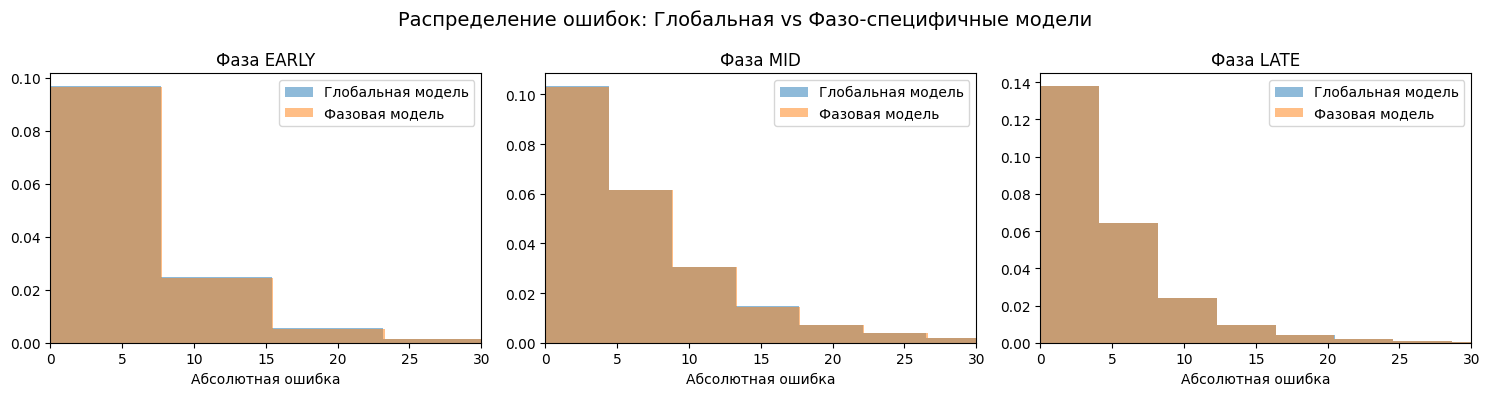

In [18]:
# Визуализация распределения ошибок по фазам
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, phase in enumerate(phases):
    phase_data = val_predictions[val_predictions['phase'] == phase]
    
    axes[i].hist(phase_data['error_global'], bins=50, alpha=0.5, label='Глобальная модель', density=True)
    axes[i].hist(phase_data['error_phase'], bins=50, alpha=0.5, label='Фазовая модель', density=True)
    axes[i].set_title(f'Фаза {phase.upper()}')
    axes[i].set_xlabel('Абсолютная ошибка')
    axes[i].legend()
    axes[i].set_xlim(0, 30)

plt.suptitle('Распределение ошибок: Глобальная vs Фазо-специфичные модели', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
# Сравнение важности признаков по фазам
print('\nТоп-10 признаков по фазам:')
print('='*80)

for phase in phases:
    importance = phase_models[phase].get_feature_importance()
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print(f'\nФаза {phase.upper()} Топ-10:')
    print(importance_df.head(10).to_string(index=False))


Топ-10 признаков по фазам:

Фаза EARLY Топ-10:
                  feature  importance
normalized_book_imbalance   11.091532
             wap_ref_diff   10.862730
           mkt_match_mean    7.557105
              mkt_buy_pct    6.650855
             mkt_imb_mean    5.012722
         signed_imbalance    4.507961
               mkt_spread    4.318229
                   spread    4.207965
               spread_pct    4.186776
              mkt_imb_std    4.119438

Фаза MID Топ-10:
                  feature  importance
              mkt_buy_pct    8.899813
normalized_book_imbalance    8.118304
             wap_ref_diff    6.216499
           price_pressure    5.282200
           mkt_match_mean    4.958460
              mkt_imb_std    4.201376
               mkt_spread    3.619911
          imbalance_delta    3.276287
             mkt_imb_mean    3.128527
                wap_delta    2.993127

Фаза LATE Топ-10:
                  feature  importance
             wap_ref_diff    8.361047
   

## 7. Итоговые результаты

In [20]:
print('='*70)
print('ВЗВЕШЕННЫЙ АНСАМБЛЬ ПО ВРЕМЕННЫМ ИНТЕРВАЛАМ - ИТОГОВЫЕ РЕЗУЛЬТАТЫ')
print('='*70)

print(f'\nБазовый уровень (advanced_features.ipynb): 5.948')
print(f'MAE глобальной модели:                      {mae_global:.6f}')
print(f'MAE ансамбля только фазовых моделей:        {mae_phase_only:.6f}')
print(f'MAE лучшего перебора по сетке:              {best_mae:.6f}')
print(f'MAE оптимального непрерывного смешивания:   {optimal_mae:.6f}')

print(f'\nЛучшее улучшение vs Базовый уровень:')
best_result = min(mae_phase_only, best_mae, optimal_mae)
print(f'  Абсолютное: {5.948 - best_result:.6f}')
print(f'  Относительное: {(5.948 - best_result)/5.948*100:.2f}%')

print(f'\nОптимальные веса для фаз:')
for phase, weight in optimal_weights.items():
    print(f'  {phase}: {weight:.3f}')

print('\n' + '='*70)

ВЗВЕШЕННЫЙ АНСАМБЛЬ ПО ВРЕМЕННЫМ ИНТЕРВАЛАМ - ИТОГОВЫЕ РЕЗУЛЬТАТЫ

Базовый уровень (advanced_features.ipynb): 5.948
MAE глобальной модели:                      5.947808
MAE ансамбля только фазовых моделей:        5.949158
MAE лучшего перебора по сетке:              5.946249
MAE оптимального непрерывного смешивания:   5.946210

Лучшее улучшение vs Базовый уровень:
  Абсолютное: 0.001790
  Относительное: 0.03%

Оптимальные веса для фаз:
  early: 0.589
  mid: 0.288
  late: 0.427



In [21]:
# Сохранение моделей
import pickle

MODELS_DIR = PROJECT_ROOT / 'models'
MODELS_DIR.mkdir(exist_ok=True)

# Сохраняем фазовые модели
for phase, model in phase_models.items():
    model.save_model(str(MODELS_DIR / f'catboost_{phase}_phase.cbm'))
    print(f'Сохранена модель {phase}')

# Сохраняем конфигурацию ансамбля
ensemble_config = {
    'optimal_weights': optimal_weights,
    'best_grid_weights': best_weights,
    'feature_cols': feature_cols,
    'cat_features': cat_features,
    'phase_results': phase_results,
    'global_mae': mae_global,
    'ensemble_mae': optimal_mae,
}

with open(MODELS_DIR / 'ensemble_config.pkl', 'wb') as f:
    pickle.dump(ensemble_config, f)

print(f'\nКонфигурация ансамбля сохранена в {MODELS_DIR / "ensemble_config.pkl"}')

Сохранена модель early
Сохранена модель mid
Сохранена модель late

Конфигурация ансамбля сохранена в /root/Optiver/models/ensemble_config.pkl
